<h1><center>Text and Voice Emotion Detection </center><h1>
    
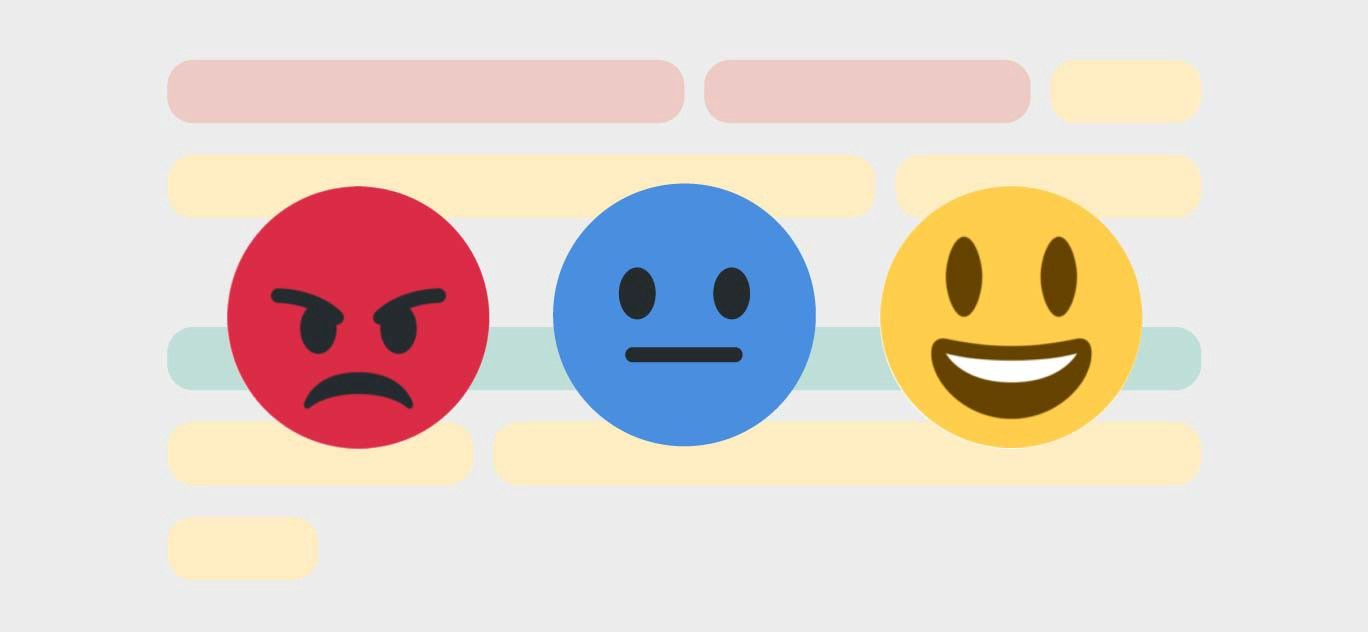

<h1><center>Import module</center></h1>

In [1]:
## import basic packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re

## importing for model

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding,Bidirectional,LSTM,GRU,Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
import urllib.request
import zipfile

## import NLTK
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

In [2]:
## to ignore Warnings

import warnings
warnings.filterwarnings('ignore')

In [3]:
## WIKI English Vectors file for images

#!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

In [27]:
os.listdir()

In [4]:
## unzip

#!unzip wiki-news-300d-1M.vec.zip

In [26]:
# os.remove('wiki-news-300d-1M.vec')

In [28]:
# os.remove('wiki-news-300d-1M.vec.zip')

<h1><center> Load Data</center></h1>

In [5]:
## lets load train data

f=open('/kaggle/input/textemotiondetection/train.txt','r')
x_train=[]
y_train=[]
for i in f:
    l=i.split(';')
    y_train.append(l[1].strip())
    x_train.append(l[0])

In [6]:
## lets load test data

f=open('/kaggle/input/textemotiondetection/test.txt','r')
x_test=[]
y_test=[]
for i in f:
    l=i.split(';')
    y_test.append(l[1].strip())
    x_test.append(l[0])

f=open('/kaggle/input/textemotiondetection/val.txt','r')
for i in f:
    l=i.split(';')
    y_test.append(l[1].strip())
    x_test.append(l[0])


<h1><center> Data Preprocessing </center></h1>

In [7]:
## lets convert dataframe

data_train=pd.DataFrame({'Text':x_train,'Emotion':y_train})
data_test=pd.DataFrame({'Text':x_test,'Emotion':y_test})
data=data_train.append(data_test,ignore_index=True)

In [8]:
## helper function to clean data

def clean_text(data):
    data=re.sub(r"(#[\d\w\.]+)", '', data)
    data=re.sub(r"(@[\d\w\.]+)", '', data)
    data=word_tokenize(data)
    return data

In [9]:
## lets apply

texts=[' '.join(clean_text(text)) for text in data.Text]
texts_train=[' '.join(clean_text(text)) for text in x_train]
texts_test=[' '.join(clean_text(text)) for text in x_test]

In [10]:
## Tokenixe the data

tokenizer=Tokenizer()
tokenizer.fit_on_texts(texts)
sequence_train=tokenizer.texts_to_sequences(texts_train)
sequence_test=tokenizer.texts_to_sequences(texts_test)
index_of_words=tokenizer.word_index
vocab_size=len(index_of_words)+1

In [11]:
## lets inilize the model

num_classes=6
embed_num_dims=300
max_seq_len=500
class_names=['anger','sadness','fear','joy','surprise','love']

In [12]:
## classes

X_train_pad=pad_sequences(sequence_train,maxlen=max_seq_len)
X_test_pad=pad_sequences(sequence_test,maxlen=max_seq_len)
encoding={'anger':0,'sadness':1,'fear':2,'joy':3,'surprise':4,'love':5}
y_train=[encoding[x] for x in data_train.Emotion]
y_test=[encoding[x] for x in data_test.Emotion]
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

In [13]:
## word embedding function

def create_embedding_matrix(filepath,word_index,embedding_dim):
    vocab_size=len(word_index)+1
    embedding_matrix=np.zeros((vocab_size,embedding_dim))
    with open(filepath) as f:
        for line in f:
            word,*vector=line.split()
            if word in word_index:
                idx=word_index[word]
                embedding_matrix[idx] = np.array(vector,dtype=np.float32)[:embedding_dim]
    return embedding_matrix
fname='wiki-news-300d-1M.vec'
embedd_matrix=create_embedding_matrix(fname,index_of_words,embed_num_dims)

<h1><center> Model Deployment </center></h1>

In [14]:
## lets build model

embedd_layer=Embedding(vocab_size,embed_num_dims,input_length=max_seq_len,weights=[embedd_matrix],trainable=False)
gru_output_size=128
bidirectional=True
model=Sequential()
model.add(embedd_layer)
model.add(Bidirectional(GRU(units=gru_output_size,dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [15]:
model.summary()

In [16]:
## train model

batch_size=128
epochs=8
hist=model.fit(X_train_pad,y_train,batch_size=batch_size,epochs=epochs,validation_data=(X_test_pad,y_test))

In [17]:
## save model

#model.save("text_emotion_classifier.h5")

<h1><center>Perfoamnce Evaluation </center></h1>

In [18]:
## lets visualize the function

plt.figure(figsize=(10, 8), dpi = 150)
loss_train = hist.history['loss']
loss_val = hist.history['val_loss']
epochs = range(1,9)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
## lets visualize the function

plt.figure(figsize=(10, 8), dpi = 150)
loss_train = hist.history['accuracy']
loss_val = hist.history['val_accuracy']
epochs = range(1,9)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<h1><center>NoteBook Deployment</center></h1>

In [20]:
## simple text deployment 

message=['I am sad.']
seq=tokenizer.texts_to_sequences(message)
padded=pad_sequences(seq,maxlen=max_seq_len)
pred=model.predict(padded)
print('Message:'+str(message))
print('Emotion:',class_names[np.argmax(pred)])

<h1><center>Gradio Deployment</center></h1>

In [21]:
# !pip install -q gradio

In [22]:
#model = load_model('text_emotion_classifier.h5')

In [24]:
# ## Gradio app

# def greet(massage):
#     seq=tokenizer.texts_to_sequences(massage)
#     padded=pad_sequences(seq,maxlen=max_seq_len)
#     pred=model.predict(padded)
#     result = class_names[np.argmax(pred)]
#     return result


# iface = gr.Interface(fn=greet, inputs="text", outputs="text")
# iface.launch()

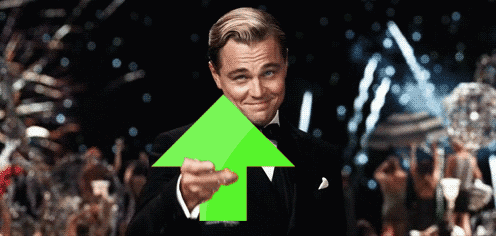

<h1> if usefull, than why are you waiting!!! just Upvote 😁 </h1>